## Classifier Performance: Constructing a QSO catalogue
#### Plot to show performance when constructing a catalogue
In this notebook, we load the results from all of our classifiers on a DESI-like subset of the BOSS DR12Q Superset, and compare the results in the context of constructing a QSO catalogue. We define different strategies for combining the classifiers' classifications, and assess which of these is preferable.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
  
import astropy
import copy
import numpy as np
from matplotlib import pyplot as plt

from quasarnet.io import read_truth
from qn_analysis import plot, strategy, utils, variables

In [2]:
qnet_path = '/global/homes/j/jfarr/Projects/QuasarNET/'
figsize = (12,8)
fontsize = 18

plt.rc('font', size=fontsize)

### Load the results from the different classifiers

In [3]:
common_specids = False

## RR parameters
include_fits_rr = False

## QN parameters
n_detect = 1
c_th = 0.5
include_c_qn = True

## SQ parameters
p_min = 0.32
include_p_sq = True

In [4]:
f_truth = qnet_path+'/data/MiniSV/SV0/SV0_truth_tile68002_night20200315.fits'
truth = read_truth([f_truth])

In [5]:
data = {}

## Load the RR data.
f_rr = '/global/homes/j/jfarr/Projects/QuasarNET_DESI/rr_results/rr_SV0_68002_20200315.fits'
data['RR coadd'] = utils.load_rr_data(f_rr,include_fits=include_fits_rr,mode='DESI')

## Load the QN_90 data.
f_qn = '/global/cfs/projectdirs/desi/users/jfarr/QuasarNET_on_DESI/output/boss_trained_models/prop_0.9/qnAll-train_0.9_coadd_0_0_lmax9800-test_coadd_lmax9800_andes_68002_20200315.fits'
data['QN_90 coadd'] = utils.load_qn_data(f_qn,n_detect=n_detect,c_th=c_th,include_c=include_c_qn,mode='DESI')

## Load the QN_10 data.
#f_qn = '/global/cfs/projectdirs/desi/users/jfarr/QuasarNET_on_DESI/output/boss_trained_models/prop_0.1/'
#data['QN_10 coadd'] = utils.load_qn_data(f_qn,n_detect=n_detect,c_th=c_th,include_c=include_c_qn)

## Load the SQ data.
#f_sq = variables.OUTDIR+'/results/sq_results/sq_sdr12q.fits'
#data['SQ'] = utils.load_sq_data(f_sq,p_min=p_min,include_p=include_p_sq)

In [6]:
for k in data.keys():
    print(k,len(data[k]))

RR coadd 5000
QN_90 coadd 1095


### Find the set of common spectra, and reduce all data to that set
This finds which spectra* are common to all datasets, and removes any that are not common. It then matches the data from each classifier to each spectrum, and produces a single data table.

\* using spec_id = plate$\times$1000000000 + mjd$\times$10000 + fiber for BOSS, or spec_id = targetid for DESI (to be updated)

In [7]:
data_table = utils.reduce_data_to_table(data,truth,
                                  include_c_qn=include_c_qn,
                                  include_p_sq=include_p_sq,
                                  include_fits_rr=include_fits_rr,
                                  common_specids=common_specids,
                                  )
data_table[:5]

SPEC_ID,OBJ_ID,ZCONF_PERSON,Z_VI,CLASS_VI,ISQSO_VI,Z_RR coadd,CLASS_RR coadd,ISQSO_RR coadd,ZWARN_RR coadd,Z_QN_90 coadd,CLASS_QN_90 coadd,ISQSO_QN_90 coadd,C_QN_90 coadd [6],Z_LINES_QN_90 coadd [6]
int64,int64,int64,float64,str8,bool,float64,str8,bool,int64,float64,str8,bool,float64,float64
35185923935178324,35185923935178324,2,1.998,QSO,True,2.001,QSO,True,0,2.021,QSO,True,1.000 .. 0.000,2.021 .. 0.159
35185923939370065,35185923939370065,2,-0.000,STAR,False,-0.000,STAR,False,0,1.045,NONQSO,False,0.000 .. 0.000,3.186 .. 0.164
35185923939371431,35185923939371431,2,2.134,QSO,True,2.134,QSO,True,0,2.146,QSO,True,1.000 .. 0.000,2.146 .. 0.336
35185923939372655,35185923939372655,2,1.507,GALAXY,False,1.507,GALAXY,False,0,0.795,NONQSO,False,0.000 .. 0.000,5.106 .. 0.053
35185923939373842,35185923939373842,1,0.000,STAR,False,-0.000,STAR,False,4,0.453,NONQSO,False,0.000 .. 0.000,3.220 .. 0.457


In [8]:
# Include only objects in the data table that have the highest confidence level, and VI redshift not equal to -1.
w = (data_table['ZCONF_PERSON']==2) & (data_table['Z_VI']>-1)
data_table = data_table[w]
print('INFO: removed {}/{} spectra, {} left'.format((~w).sum(),len(w),len(data_table)))

INFO: removed 220/917 spectra, 697 left


In [9]:
w = (data_table['ISQSO_QN_90 coadd'] | data_table['ISQSO_RR coadd']) & (data_table['CLASS_VI']=='GALAXY')
data_table[w]

SPEC_ID,OBJ_ID,ZCONF_PERSON,Z_VI,CLASS_VI,ISQSO_VI,Z_RR coadd,CLASS_RR coadd,ISQSO_RR coadd,ZWARN_RR coadd,Z_QN_90 coadd,CLASS_QN_90 coadd,ISQSO_QN_90 coadd,C_QN_90 coadd [6],Z_LINES_QN_90 coadd [6]
int64,int64,int64,float64,str8,bool,float64,str8,bool,int64,float64,str8,bool,float64,float64
35185929941418536,35185929941418536,2,1.080,GALAXY,False,1.080,GALAXY,False,0,1.079,QSO,True,0.000 .. 0.000,2.826 .. 0.144
35185929954003617,35185929954003617,2,0.857,GALAXY,False,0.856,GALAXY,False,0,0.850,QSO,True,0.000 .. 0.000,6.494 .. -0.200
35185935926690083,35185935926690083,2,0.561,GALAXY,False,0.561,GALAXY,False,0,3.866,QSO,True,0.831 .. 0.000,3.866 .. -0.303
35185941945516472,35185941945516472,2,0.949,GALAXY,False,0.949,GALAXY,False,0,0.950,QSO,True,0.000 .. 0.000,4.144 .. -0.067
35185941962295996,35185941962295996,2,0.911,GALAXY,False,0.911,GALAXY,False,0,0.995,QSO,True,0.000 .. 0.000,2.041 .. 0.159
35185953911868512,35185953911868512,2,0.421,GALAXY,False,0.421,GALAXY,False,0,0.421,QSO,True,0.000 .. 1.000,5.347 .. 0.419
35185953916061917,35185953916061917,2,0.665,GALAXY,False,0.428,QSO,True,0,5.209,NONQSO,False,0.000 .. 0.000,5.209 .. 0.232
35185965874022087,35185965874022087,2,0.469,GALAXY,False,0.470,GALAXY,False,0,0.465,QSO,True,0.000 .. 1.000,2.620 .. 0.466
35185983829836464,35185983829836464,2,1.485,GALAXY,False,1.485,GALAXY,False,0,1.464,QSO,True,0.000 .. 0.000,4.550 .. -0.375


### Evaluate performance of classifiers at constructing a QSO catalogue.
xxx

In [10]:
data_table_archive = copy.deepcopy(data_table)

In [11]:
# Define some parameters
dv_max = 6000. #km/s
show_correctwrongzbin = False
zbins = [(0.9,2.1),(2.1,None)]
desi_nqso=[1.7*10**6,0.7*10**6]

In [12]:
## Define the strategies
stratdefs = {}

## Single classifiers.
# QN definitions.
c_kwargs = {'c_th': 0.5, 'n_detect': 1}
cf_kwargs = {'qn_name': 'QN_90 coadd'}
strat = strategy.Strategy('qn',cf_kwargs=cf_kwargs)
pred = strat.predict(data_table,c_kwargs=c_kwargs)
stratdefs['QN coadd c_th=0.5'] = {'isqso': pred.isqso, 'z': pred.z}

# RR definitions.
c_kwargs = {'zwarn': False}
cf_kwargs = {'rr_name': 'RR coadd'}
strat = strategy.Strategy('rr',cf_kwargs=cf_kwargs)
pred = strat.predict(data_table,c_kwargs=c_kwargs)
stratdefs['RR coadd'] = {'isqso': pred.isqso, 'z': pred.z}



## Simple & | combinations of classifiers.
# QN|RR definitions.
c_kwargs = {'qn_kwargs': {'c_th': 0.5, 'n_detect': 1},
            'rr_kwargs': {'zwarn': False}}
cf_kwargs = {'qn_name': 'QN_90 coadd',
             'rr_name': 'RR coadd'}
strat = strategy.Strategy('qnorrr',cf_kwargs=cf_kwargs)
pred = strat.predict(data_table,c_kwargs=c_kwargs)
stratdefs['QN|RR'] = {'isqso': pred.isqso, 'z': pred.z}

# QN&RR definitions
c_kwargs = {'qn_kwargs': {'c_th': 0.5, 'n_detect': 1},
            'rr_kwargs': {'zwarn': False},
            'dv_max': dv_max}
cf_kwargs = {'qn_name': 'QN_90 coadd',
             'rr_name': 'RR coadd'}
strat = strategy.Strategy('qnandrr',cf_kwargs=cf_kwargs)
pred = strat.predict(data_table,c_kwargs=c_kwargs)
stratdefs['QN&RR'] = {'isqso': pred.isqso, 'z': pred.z}


## Strategies involving VI.
# RR+VI definitions
c_kwargs = {}
cf_kwargs = {'rr_name': 'RR coadd'}
strat = strategy.Strategy('rrplusvi',cf_kwargs=cf_kwargs)
pred = strat.predict(data_table,c_kwargs=c_kwargs)
stratdefs['RR+VI'] = {'isqso': pred.isqso, 'z': pred.z}

# RR+VI alt. definitions
c_kwargs = {}
cf_kwargs = {'rr_name': 'RR coadd'}
strat = strategy.Strategy('rrplusvialt',cf_kwargs=cf_kwargs)
pred = strat.predict(data_table,c_kwargs=c_kwargs)
stratdefs['RR+VI alt.'] = {'isqso': pred.isqso, 'z': pred.z}

# QN+VI definitions.
c_kwargs = {'c_th_hi': 0.9, 'c_th_lo': 0.1, 'n_detect': 1}
cf_kwargs = {'qn_name': 'QN_90 coadd'}
strat = strategy.Strategy('qnplusvi',cf_kwargs=cf_kwargs)
pred = strat.predict(data_table,c_kwargs=c_kwargs)
stratdefs['QN+VI'] = {'isqso': pred.isqso, 'z': pred.z}

# QN&RR+VI definition 1.
# Classifies as QSO when QN has c>cth or if RR classifies as QSO without zwarn.
# Asks for VI when if one classifier says QSO but the other doesn't, or if the redshifts disagree.
c_kwargs = {'qn_kwargs': {'c_th': 0.6, 'n_detect': 1},
            'rr_kwargs': {'zwarn': False}}
cf_kwargs = {'qn_name': 'QN_90 coadd',
             'rr_name': 'RR coadd'}
strat = strategy.Strategy('qnandrrplusvi',cf_kwargs=cf_kwargs)
pred = strat.predict(data_table,c_kwargs=c_kwargs)
stratdefs['QN&RR+VI'] = {'isqso': pred.isqso, 'z': pred.z, 'label': 'QN&RR\n+VI'}

# QN&RR+VI definitions 2.
# Classifies as QSO when QN has c>cth_hi or if RR classifies as QSO without zwarn.
# Asks for VI if QN says c>cth_hi but RR has a zwarn.
# Also if RR says QSO without zwarn, and QN says cth_lo<c<cth_hi.
# Rejects if either QN says c<cth_lo or 
c_kwargs = {'c_th_hi': 0.9, 'c_th_lo': 0.1, 'n_detect': 1}
cf_kwargs = {'qn_name': 'QN_90 coadd',
             'rr_name': 'RR coadd'}
strat = strategy.Strategy('qnandrrplusviadv',cf_kwargs=cf_kwargs)
pred = strat.predict(data_table,c_kwargs=c_kwargs)
stratdefs['QN&RR+VI adv.'] = {'isqso': pred.isqso, 'z': pred.z, 'label': 'QN&RR\n+VI adv.'}

# QN+RR+VI definitions.
# Classifies as QSO when QN has c>cth_hi or if RR classifies as QSO without zwarn.
c_kwargs = {'c_th_hi': 0.9, 'c_th_lo': 0.1, 'n_detect': 1}
cf_kwargs = {'qn_name': 'QN_90 coadd',
             'rr_name': 'RR coadd'}
strat = strategy.Strategy('qnplusrrplusvi',cf_kwargs=cf_kwargs)
pred = strat.predict(data_table,c_kwargs=c_kwargs)
stratdefs['QN+RR+VI'] = {'isqso': pred.isqso, 'z': pred.z, 'label': 'QN+RR+VI'}

INFO: RR+VI sends 6/697 (0.9%) spectra to VI
INFO: RR+VI alt. sends 43/697 (6.2%) spectra to VI
INFO: QN+VI sends 16/697 (2.30%) spectra to VI
INFO: QN&RR+VI sends 66/697 (9.5%) spectra to VI
INFO: RR&QN+VI adv. sends 10/697 (1.4%) spectra to VI
INFO: RR+QN+VI sends 3/697 (0.4%) spectra to VI


In [29]:
## Experiment to make DR14 classification strategy.
# Looks at 5 lowest reduced chi2 

## Choose which classifier we want to use (needs to be one with classes, not just ISQSO)
c = 'PIPE'

## Go through the points at the top of page 4 of https://www.aanda.org/articles/aa/pdf/2018/05/aa32445-17.pdf 
# 1. if the first SDSS pipeline identification is STAR, then the
#    resulting classification is STAR;
isstar = data_table['CLASS_{}'.format(c)]=='STAR'

# 2. if the first SDSS pipeline identification is GALAXY with
#    zpipeline < 1, then the resulting classification is GALAXY;
isgal = (data_table['CLASS_{}'.format(c)]=='GALAXY') & (data_table['Z_{}'.format(c)]<1.)

## This seems weird - surely it basically includes the same objects as above?
## Is it a typo? Should it say >=?
# 3. if the first SDSS pipeline identification is GALAXY with
#    zpipeline ≤ 1 and at least two other SDSS pipeline iden-
#    tifications are GALAXY, then the resulting classification is
#    GALAXY;
isgal |= (((data_table['CLASS_{}'.format(c)]=='GALAXY') & (data_table['Z_{}'.format(c)]<=1.)) & \
         (((data_table['FIT_SPECTYPE_{}'.format(c)].data[:,1:5]=='GALAXY').sum(axis=1))>=2))

# 4. if the first SDSS pipeline identification is QSO with
#    ZWARNING = 0, then the resulting classification is QSO, except
#    if at least two other SDSS pipeline identifications are STAR.
#    In such a case, the resulting identification is STAR;
twostar = (((data_table['FIT_SPECTYPE_{}'.format(c)].data[:,1:5]=='STAR').sum(axis=1))>=2)
isqso = (data_table['CLASS_{}'.format(c)]=='QSO') & (data_table['ZWARN_{}'.format(c)]==0) & (~twostar)
isstar |= (data_table['CLASS_{}'.format(c)]=='QSO') & (data_table['ZWARN_{}'.format(c)]==0) & (twostar)

# 5. if the first pipeline identification is QSO with ZWARNING > 0
#    and at least two alternate SDSS pipeline identifications are
#    STAR, then the resulting identification is STAR
isstar |= (data_table['CLASS_{}'.format(c)]=='QSO') & (data_table['ZWARN_{}'.format(c)]>0) & (twostar)

# At this stage, the redshift measurement we consider for automat-
# ically classified objects is the redshift estimate of the overall best
# fit of the SDSS pipeline, except if the automated identification
# is STAR. In that case, we set the redshift to 0. 
z = copy.deepcopy(data_table['Z_{}'.format(c)].data)
z[isstar] = 0.

# If an object does not pass any of these conditions, the resulting classification is
# UNKNOWN and it is added to the list of objects that require visual
# inspection
vi = (~isstar) & (~isgal) & (~isqso)

isqso[vi] = copy.deepcopy(data_table['ISQSO_VI'].data[vi])
z[vi] = copy.deepcopy(data_table['Z_VI'].data[vi])
print('INFO: DR14Q sends {}/{} ({:1.1%}) spectra to VI'.format(vi.sum(),len(data_table),vi.sum()/len(data_table)))

stratdefs['DR14Q'] = {'isqso': isqso, 'z': z, 'label': 'DR14Q'}

INFO: DR14Q sends 29546/601912 (4.9%) spectra to VI


In [30]:
## Experiment to make DR16 classification strategy.
# Looks at 5 lowest reduced chi2
# Then uses QN to reduce the number of VIs

## Choose which classifier we want to use (needs to be one with classes, not just ISQSO)
c = 'PIPE'

## Go through the points on page 4
# 1. If the best model fit for the spectrum is STAR, the spectrum is classified as a STAR.
isstar = data_table['CLASS_{}'.format(c)]=='STAR'

# 2. If the best model fit for the spectrum is GALAXY and Zpipeline < 1, then the spectrum is classified as a GALAXY.
isgal = (data_table['CLASS_{}'.format(c)]=='GALAXY') & (data_table['Z_{}'.format(c)]<1.)

# 3. If the best model fit for the spectrum is GALAXY and Zpipeline ≥ 1, and at least one other fit is GALAXY, then the spectrum is classified as a GALAXY.
isgal |= (((data_table['CLASS_{}'.format(c)]=='GALAXY') & (data_table['Z_{}'.format(c)]>=1.)) & \
         (((data_table['FIT_SPECTYPE_{}'.format(c)].data[:,1:5]=='GALAXY').sum(axis=1))>=1))

# 4. If the best model fit for the spectrum is QSO and 2 or more other model fits are STAR, then the spec- trum is classified as a STAR.
twostar = (((data_table['FIT_SPECTYPE_{}'.format(c)].data[:,1:5]=='STAR').sum(axis=1))>=2)
isstar |= (data_table['CLASS_{}'.format(c)]=='QSO') & (twostar)

# 5. If the best model fit for the spectrum is QSO, fewer than 2 other model fits are STAR, and ZWARNING = 0, the spectrum is classified as a QSO.
isqso = (data_table['CLASS_{}'.format(c)]=='QSO') & (~twostar) & (data_table['ZWARN_{}'.format(c)]==0)

# 6. If a spectrum meets none of these criteria, it is se- lected for visual inspection (MY CLASS ISA = VI).
vi = (~isstar) & (~isgal) & (~isqso)

## I assume that the redshifts used at this stage are the pipeline ones?
z = np.zeros(len(data_table))
w = isstar|isgal|isqso
z[w] = copy.deepcopy(data_table['Z_{}'.format(c)].data[w])

# After the objects were clas- sified using this schema, any object that had an initial classification set to QSO and had Zpipeline > 3.5 was reclassified for visual inspection.
vi |= ((isqso) & (z>3.5))

# The QuasarNET algorithm produced a binary quasar flag and systemic redshift, IS QSO QN and Z QN respec- tively. This schema used the classification results stored in MY CLASS ISA to reclassify objects based on confident QuasarNET classifications and recorded these new clas- sifications in MY CLASS PQN:
c_qn = 'QN coadd'
## Don't know the confidence threshold and ndetect?
c_th = 0.5
n_detect = 1
isqso_qn = ((data_table['C_{}'.format(c_qn)]>c_th).sum(axis=1)>=n_detect)
z_qn = copy.deepcopy(data_table['Z_{}'.format(c_qn)].data)

# 1. If MY CLASS ISA = VI and the QuasarNET field IS QSO = 0, then the classification was kept as VI.

# 2. If MY CLASS ISA = VI, the QuasarNET field IS QSO = 1, and Z QN < 2.0, then the classifica- tion changed to QSO.
w = (vi & isqso_qn & (z_qn<2.0))
print(w.sum())
isqso |= w
## What z do we use in this case?
z[w] = z_qn[w]
vi = (vi & (~w))

# 3. If MY CLASS ISA = VI, the QuasarNET field IS QSO = 1, and Z QN ≥ 2.0, then the classifica- tion did not change (MY CLASS PQN = VI).


isqso[vi] = copy.deepcopy(data_table['ISQSO_VI'].data[vi])
z[vi] = copy.deepcopy(data_table['Z_VI'].data[vi])
print('INFO: DR16Q sends {}/{} ({:1.1%}) spectra to VI'.format(vi.sum(),len(data_table),vi.sum()/len(data_table)))

stratdefs['DR16Q'] = {'isqso': isqso, 'z': z, 'label': 'DR16Q'}

6663
INFO: DR16Q sends 26163/601912 (4.3%) spectra to VI


In [92]:
c_qn = 'QN coadd'
"""c_th_lo = 0.1
c_th_hi = 0.9
n_detect = 1
isqso_qn_lo = ((data_table['C_{}'.format(c_qn)]>c_th_lo).sum(axis=1)>=n_detect)
isqso_qn_hi = ((data_table['C_{}'.format(c_qn)]>c_th_hi).sum(axis=1)>=n_detect)
qn_ws = [~isqso_qn_lo,(isqso_qn_lo&(~isqso_qn_hi)),isqso_qn_hi]"""

c_rr = 'RR coadd'

"""rr_ws = [(data_table['ISQSO_{}'.format(c_rr)] & (data_table['ZWARN_{}'.format(c_rr)]==0)),
         (data_table['ISQSO_{}'.format(c_rr)] & (data_table['ZWARN_{}'.format(c_rr)]!=0)),
         ((~data_table['ISQSO_{}'.format(c_rr)]) & (data_table['ZWARN_{}'.format(c_rr)]==0)),
         ((~data_table['ISQSO_{}'.format(c_rr)]) & (data_table['ZWARN_{}'.format(c_rr)]!=0)),
        ]"""

drc2 = data_table['FIT_RCHI2_{}'.format(c_rr)].data - data_table['FIT_RCHI2_{}'.format(c_rr)].data.min(axis=1).reshape((len(data_table),1))
"""rr_ws = [((data_table['FIT_SPECTYPE_{}'.format(c_rr)]=='QSO') & (drc2<=0.)).sum(axis=1)>0,
         ((data_table['FIT_SPECTYPE_{}'.format(c_rr)]=='QSO') & (0.<drc2) & (drc2<=0.005)).sum(axis=1)>0,
         ((data_table['FIT_SPECTYPE_{}'.format(c_rr)]=='QSO') & (0.005<drc2) & (drc2<=0.01)).sum(axis=1)>0,
         ((data_table['FIT_SPECTYPE_{}'.format(c_rr)]=='QSO') & (0.01<drc2) & (drc2<=0.015)).sum(axis=1)>0,
         ((data_table['FIT_SPECTYPE_{}'.format(c_rr)]=='QSO') & (0.015<drc2) & (drc2<=0.02)).sum(axis=1)>0,
        ]"""

nbins_c_th = 1
nbins_dc2 = 50
c_th_bin_edges = np.linspace(0.,1.,nbins_c_th+1)
dc2_bin_edges = np.linspace(0.,5.,nbins_dc2+1)

nobj = np.zeros((nbins_dc2,nbins_c_th))
nqso = np.zeros((nbins_dc2,nbins_c_th))

for i in range(nbins_dc2):
    w_rr = ((data_table['FIT_SPECTYPE_{}'.format(c_rr)]=='QSO') & (dc2_bin_edges[i]<drc2) & (drc2<=dc2_bin_edges[i+1])).sum(axis=1)>0
    for j in range(nbins_c_th):
        w_qn = (c_th_bin_edges[j]<(data_table['C_{}'.format(c_qn)]).max(axis=1)) & ((data_table['C_{}'.format(c_qn)]).max(axis=1)<=c_th_bin_edges[j+1])

        nobj[i,j] = ((w_qn)&(w_rr)).sum()
        nqso[i,j] = ((w_qn)&(w_rr)&data_table['ISQSO_VI']).sum()
        print(i,j,end='\r')
        
#print((nqso/nobj).round(4))
#print(nobj.astype(int))
#print(nqso.astype(int))
#print((nobj-nqso).astype(int))

In [ ]:
isqso = isqso_qn_hi
z = copy.deepcopy(data_table['Z_{}'.format(c_qn)].data)

vi = (qn_ws[1]) | \
        (qn_ws[0] & rr_ws[0])
isqso[vi] = copy.deepcopy(data_table['ISQSO_VI'].data[vi])
z[vi] = copy.deepcopy(data_table['Z_VI'].data[vi])

print('INFO: test sends {}/{} ({:1.1%}) spectra to VI'.format(vi.sum(),len(data_table),vi.sum()/len(data_table)))

stratdefs['test'] = {'isqso': isqso, 'z': z, 'label': 'test'}

In [31]:
## Experimental strategies which haven't yet been formalised into the module definitions.

# RR rchi2 definitions.
rr_name = 'RR coadd'
drc2_th = 0.
drc2 = data_table['FIT_RCHI2_{}'.format(rr_name)].data - data_table['FIT_RCHI2_{}'.format(rr_name)].data.min(axis=1).reshape((len(data_table),1))
best_rchi2 = (drc2==0)
zwarn = ((data_table['FIT_ZWARN_{}'.format(rr_name)]>0) & best_rchi2).any(axis=1)
isqso = ((data_table['FIT_SPECTYPE_{}'.format(rr_name)]=='QSO') & best_rchi2).any(axis=1) & (~zwarn)
z = np.zeros(len(data_table))
z[best_rchi2.sum(axis=1)>0] = copy.deepcopy(data_table['FIT_Z_{}'.format(rr_name)][best_rchi2])
stratdefs['RR coadd rchi2'] = {'isqso': isqso, 'z': z}

c_th = 0.5
z = copy.deepcopy(stratdefs['RR coadd rchi2']['z'])
z[stratdefs['QN coadd c_th={}'.format(c_th)]['isqso']] = stratdefs['QN coadd c_th={}'.format(c_th)]['z'][stratdefs['QN coadd c_th={}'.format(c_th)]['isqso']]
isqso = stratdefs['RR coadd rchi2']['isqso'] | stratdefs['QN coadd c_th={}'.format(c_th)]['isqso']
stratdefs['QN|RR coadd rchi2'] = {'isqso': isqso, 'z': z}

c_th = 0.5
z = copy.deepcopy(stratdefs['RR coadd rchi2']['z'])
z[stratdefs['QN coadd c_th={}'.format(c_th)]['isqso']] = stratdefs['QN coadd c_th={}'.format(c_th)]['z'][stratdefs['QN coadd c_th={}'.format(c_th)]['isqso']]
isqso = stratdefs['RR coadd rchi2']['isqso'] & stratdefs['QN coadd c_th={}'.format(c_th)]['isqso']
stratdefs['QN&RR coadd rchi2'] = {'isqso': isqso, 'z': z}

In [ ]:
# QN 2line with zconsistent definitions.
qn_name = 'QN coadd'

best = data_table['C_{}'.format(qn_name)].data.argsort(axis=1)[:,-1]
best_flat = (best + np.arange(len(data_table))*data_table['C_{}'.format(qn_name)].shape[1]).astype(int)
zbest = data_table['Z_LINES_{}'.format(qn_name)].flatten()[best_flat]

best2 = data_table['C_{}'.format(qn_name)].argsort(axis=1)[:,-2]
best2_flat = (best2 + np.arange(len(data_table))*data_table['C_{}'.format(qn_name)].shape[1]).astype(int)
zbest2 = data_table['Z_LINES_{}'.format(qn_name)].flatten()[best2_flat]

dv_top2z = strategy.get_dv(zbest,zbest2,data_table['Z_VI'],use_abs=True)
top2z_consistent = dv_top2z<=dv_max

c_kwargs = {'c_th': 0.5, 'n_detect': 2}
cf_kwargs = {'qn_name': qn_name}
strat = strategy.Strategy('qn',cf_kwargs=cf_kwargs)
pred = strat.predict(data_table,c_kwargs=c_kwargs)
stratdefs['QN2line coadd zcons'] = {'isqso': pred.isqso & top2z_consistent, 'z': pred.z}

In [13]:
# QN c_th value definitions.
c_th_values = np.linspace(0.,1.,101)
for c_th in c_th_values:
    c_kwargs = {'c_th': c_th, 'n_detect': 1}
    cf_kwargs = {'qn_name': 'QN_90 coadd'}
    strat = strategy.Strategy('qn',cf_kwargs=cf_kwargs)
    pred = strat.predict(data_table,c_kwargs=c_kwargs)
    stratdefs['QN coadd c_th={}'.format(c_th)] = {'isqso': pred.isqso, 'z': pred.z}
    
    c_kwargs = {'c_th': c_th, 'n_detect': 2}
    cf_kwargs = {'qn_name': 'QN_90 coadd'}
    strat = strategy.Strategy('qn',cf_kwargs=cf_kwargs)
    pred = strat.predict(data_table,c_kwargs=c_kwargs)
    stratdefs['QN2line coadd c_th={}'.format(c_th)] = {'isqso': pred.isqso, 'z': pred.z}

In [14]:
# Check that we haven't accidentally overwritten any data.
assert (data_table==data_table_archive).all()

INFO:    696/   697 (99.9%) spectra used


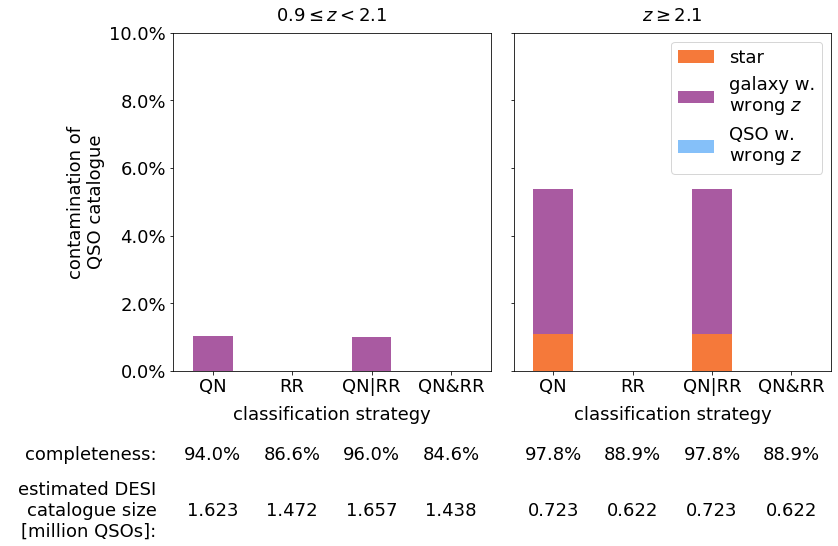

In [15]:
## Plot comparing QN, RR and simple combinations.
plot_strategies = ['QN coadd c_th=0.5','RR coadd','QN|RR','QN&RR']
names = {'QN coadd c_th=0.5': 'QN', 'RR coadd': 'RR', 'QN|RR': 'QN|RR','QN&RR': 'QN&RR'}
filename = '../plots/desi_classifier_performance_constructing_a_catalogue.pdf'
ymax = 0.1

# Get the strategies.
strategies = {names[s]:stratdefs[s] for s in plot_strategies}

# Determine the filter.
data_used = ['QN_90 coadd','RR coadd']
filt = utils.get_data_filter(data_table,data_used)

# Make the plot.
fig, axs = plot.plot_catalogue_performance(data_table,strategies,filename=filename,
                           figsize=figsize,zbins=zbins,desi_nqso=desi_nqso,
                           dv_max=dv_max,show_correctwrongzbin=False,
                           verbose=False,nydec=1,ymax=ymax,filter=filt,
                           add_bar_heights=False)
plt.show()

INFO:    696/   697 (99.9%) spectra used


/global/u1/j/jfarr/.conda/envs/qnet/lib/python3.7/site-packages/qn_analysis/plot.py:892: RuntimeWarning: invalid value encountered in true_divide
  pstar = np.array([strategies[s]['nstar'] for s in strategies.keys()])/ncat
/global/u1/j/jfarr/.conda/envs/qnet/lib/python3.7/site-packages/qn_analysis/plot.py:893: RuntimeWarning: invalid value encountered in true_divide
  pgalwrongz = np.array([strategies[s]['ngalwrongz'] for s in strategies.keys()])/ncat
/global/u1/j/jfarr/.conda/envs/qnet/lib/python3.7/site-packages/qn_analysis/plot.py:894: RuntimeWarning: invalid value encountered in true_divide
  pqsowrongz = np.array([strategies[s]['nqsowrongz'] for s in strategies.keys()])/ncat
/global/u1/j/jfarr/.conda/envs/qnet/lib/python3.7/site-packages/qn_analysis/plot.py:895: RuntimeWarning: invalid value encountered in true_divide
  pcorrectwrongzbin = np.array([strategies[s]['ncorrectwrongzbin'] for s in strategies.keys()])/ncat
/global/u1/j/jfarr/.conda/envs/qnet/lib/python3.7/site-packages/

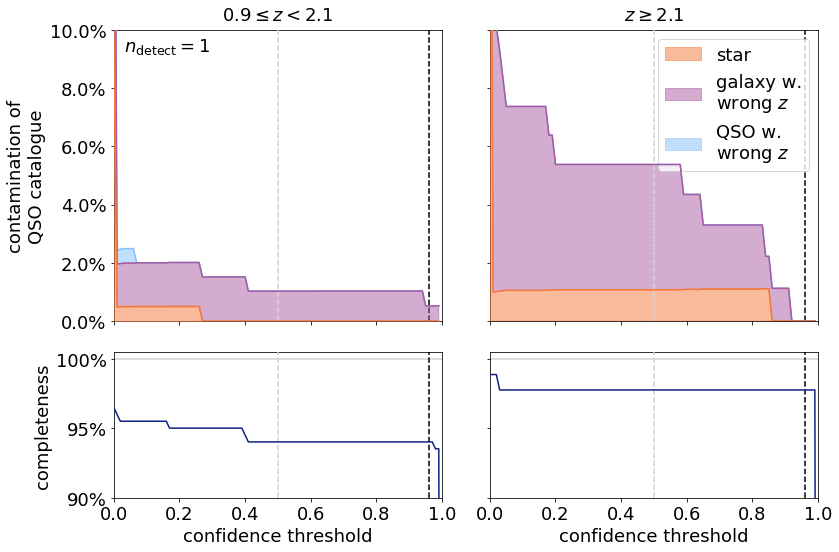

In [34]:
## Alternative plot to show different QN c_th options.
plot_strategies = ['QN coadd c_th={}'.format(c_th) for c_th in c_th_values]
filename = '../plots/classifier_performance_constructing_a_catalogue_qncth_alt.pdf'
ymax = 0.1

# Get the strategies.
strategies = {s:stratdefs[s] for s in plot_strategies}

# Determine the filter.
data_used = ['QN_90 coadd']
filt = utils.get_data_filter(data_table,data_used)

# Make the plot.
fig, axs = plot.plot_catalogue_performance_vs_cth(data_table,strategies,filename=filename,
                           figsize=(12,8),zbins=zbins,desi_nqso=desi_nqso,
                           dv_max=dv_max,show_correctwrongzbin=False,
                           verbose=False,nydec=1,ymax=ymax,filter=filt,
                           ymin2=0.90,ymax2=1.005,c_th=c_th_values)

for ax in axs.flatten():
    ax.axvline(x=0.96,c='k',ls='--')
axs[0,0].text(0.03,0.98,r'$n_\mathrm{detect}=1$',ha='left',va='top',transform=axs[0,0].transAxes)

plt.show()

INFO:    696/   697 (99.9%) spectra used


/global/u1/j/jfarr/.conda/envs/qnet/lib/python3.7/site-packages/qn_analysis/plot.py:892: RuntimeWarning: invalid value encountered in true_divide
  pstar = np.array([strategies[s]['nstar'] for s in strategies.keys()])/ncat
/global/u1/j/jfarr/.conda/envs/qnet/lib/python3.7/site-packages/qn_analysis/plot.py:893: RuntimeWarning: invalid value encountered in true_divide
  pgalwrongz = np.array([strategies[s]['ngalwrongz'] for s in strategies.keys()])/ncat
/global/u1/j/jfarr/.conda/envs/qnet/lib/python3.7/site-packages/qn_analysis/plot.py:894: RuntimeWarning: invalid value encountered in true_divide
  pqsowrongz = np.array([strategies[s]['nqsowrongz'] for s in strategies.keys()])/ncat
/global/u1/j/jfarr/.conda/envs/qnet/lib/python3.7/site-packages/qn_analysis/plot.py:895: RuntimeWarning: invalid value encountered in true_divide
  pcorrectwrongzbin = np.array([strategies[s]['ncorrectwrongzbin'] for s in strategies.keys()])/ncat
/global/u1/j/jfarr/.conda/envs/qnet/lib/python3.7/site-packages/

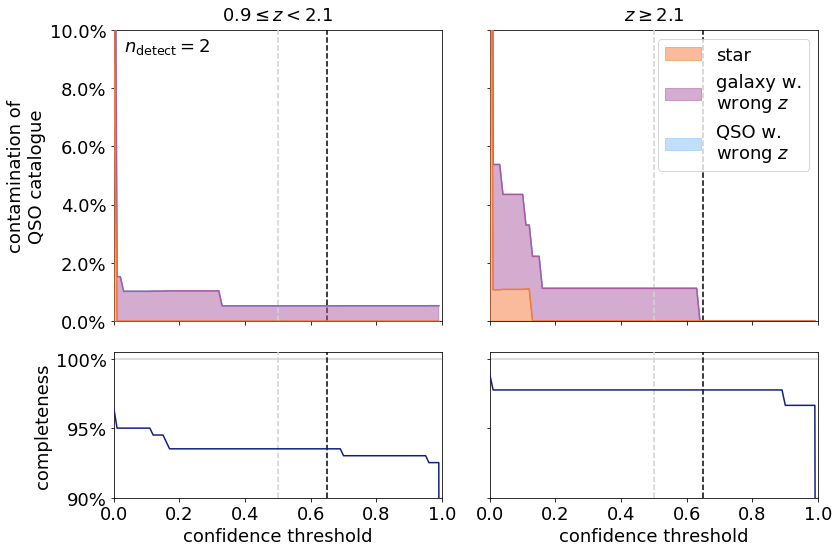

In [33]:
## Alternative plot to show different QN c_th options.
plot_strategies = ['QN2line coadd c_th={}'.format(c_th) for c_th in c_th_values]
filename = '../plots/classifier_performance_constructing_a_catalogue_qncth_alt.pdf'
ymax = 0.1

# Get the strategies.
strategies = {s:stratdefs[s] for s in plot_strategies}

# Determine the filter.
data_used = ['QN_90 coadd']
filt = utils.get_data_filter(data_table,data_used)

# Make the plot.
fig, axs = plot.plot_catalogue_performance_vs_cth(data_table,strategies,filename=filename,
                           figsize=(12,8),zbins=zbins,desi_nqso=desi_nqso,
                           dv_max=dv_max,show_correctwrongzbin=False,
                           verbose=False,nydec=1,ymax=ymax,filter=filt,
                           ymin2=0.90,ymax2=1.005,c_th=c_th_values)

for ax in axs.flatten():
    ax.axvline(x=0.65,c='k',ls='--')
axs[0,0].text(0.03,0.98,r'$n_\mathrm{detect}=2$',ha='left',va='top',transform=axs[0,0].transAxes)

plt.show()

INFO: 506217/601912 (84.1%) spectra used


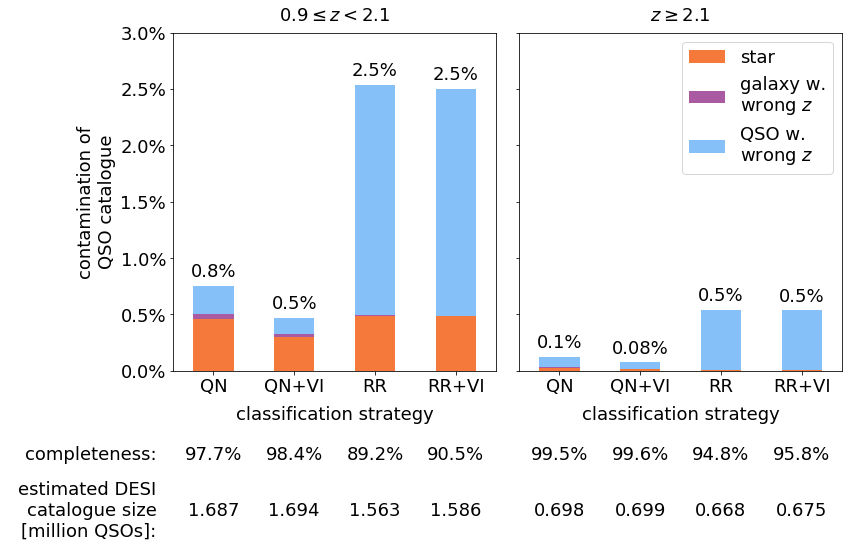

In [35]:
## Plot to test introducing VI on ``difficult'' spectra.
plot_strategies = ['QN coadd c_th=0.5','QN+VI','RR coadd','RR+VI']#,'RR+VI alt.']
names = {'QN coadd c_th=0.5': 'QN', 'QN+VI': 'QN+VI', 'RR coadd': 'RR', 'RR+VI': 'RR+VI',}#'RR+VI alt.':'RR+VI alt.'}
filename = '../plots/classifier_performance_constructing_a_catalogue_plusvi.pdf'
ymax = 0.03

# Get the strategies.
strategies = {names[s]:stratdefs[s] for s in plot_strategies}

# Determine the filter.
data_used = ['QN coadd','RR coadd']
filt = utils.get_data_filter(data_table,data_used)

# Make the plot.
fig, axs = plot.plot_catalogue_performance(data_table,strategies,filename=filename,
                           figsize=figsize,zbins=zbins,desi_nqso=desi_nqso,
                           dv_max=dv_max,show_correctwrongzbin=False,
                           verbose=False,nydec=1,ymax=ymax,filter=filt)
plt.show()

In [60]:
## Plot to further test introducing VI on ``difficult'' spectra.
plot_strategies = ['QN+VI','RR+VI','QN&RR+VI','QN&RR+VI adv.','test']
names = {'QN+VI': 'QN+VI', 'RR+VI': 'RR+VI', 'QN&RR+VI': 'QN&RR+VI', 'QN&RR+VI adv.': 'QN&RR+VI adv.', 'test': 'test'}
filename = '../plots/classifier_performance_constructing_a_catalogue_complex.pdf'
ymax = 0.05

# Get the strategies.
strategies = {names[s]:stratdefs[s] for s in plot_strategies}

# Determine the filter.
data_used = ['QN coadd','RR coadd']
filt = utils.get_data_filter(data_table,data_used)

# Make the plot.
fig, axs = plot.plot_catalogue_performance(data_table,strategies,filename=filename,
                           figsize=figsize,zbins=zbins,desi_nqso=desi_nqso,
                           dv_max=dv_max,show_correctwrongzbin=False,
                           verbose=False,nydec=0,ymax=ymax,filter=filt)
plt.show()

KeyError: 'test'

INFO: 506217/601912 (84.1%) spectra used


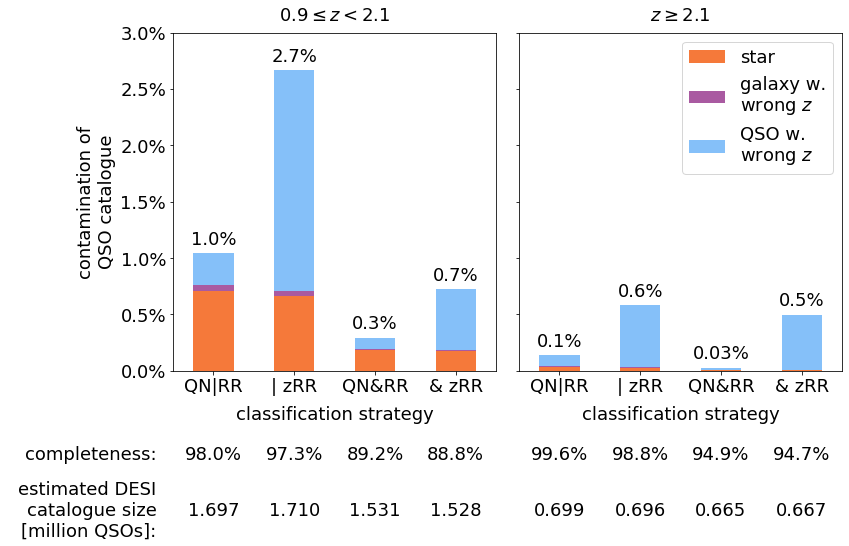

In [28]:
## Compare choice of redshift in simple combination strategies.
plot_strategies = ['QN|RR','| zRR','QN&RR','& zRR']
names = {'QN|RR': 'QN|RR', '| zRR': '| zRR', 'QN&RR': 'QN&RR', '& zRR': '& zRR'}
filename = '../plots/classifier_performance_constructing_a_catalogue_zrr.pdf'
ymax = 0.03

# Get the strategies.
strategies = {names[s]:stratdefs[s] for s in plot_strategies}

# Determine the filter.
data_used = ['QN coadd','RR coadd']
filt = utils.get_data_filter(data_table,data_used)

# Make the plot.
fig, axs = plot.plot_catalogue_performance(data_table,strategies,filename=filename,
                           figsize=figsize,zbins=zbins,desi_nqso=desi_nqso,
                           dv_max=dv_max,show_correctwrongzbin=False,
                           verbose=False,nydec=1,ymax=ymax,filter=filt)
plt.show()

INFO: 506217/601912 (84.1%) spectra used


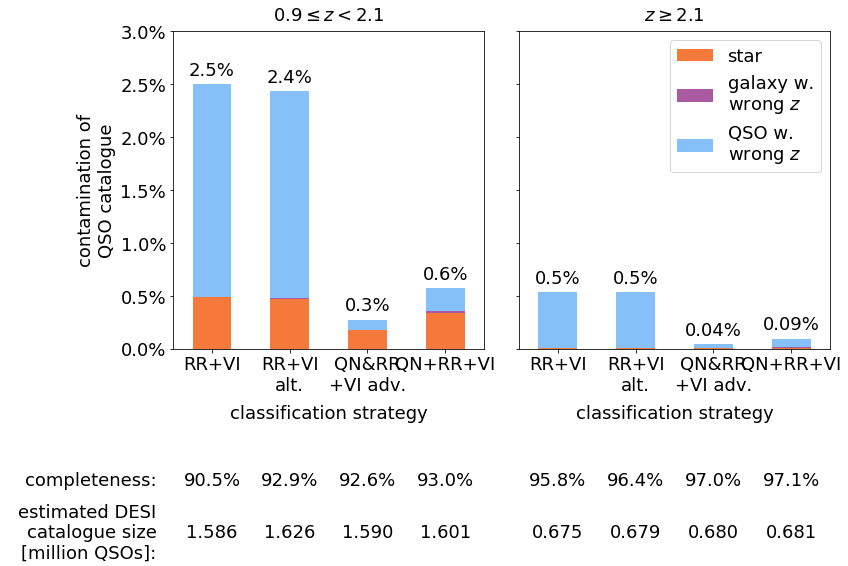

In [29]:
## Plot to further test introducing VI on ``difficult'' spectra.
plot_strategies = ['RR+VI','RR+VI alt.','QN&RR+VI adv.','QN+RR+VI']
names = {'RR+VI': 'RR+VI', 'RR+VI alt.': 'RR+VI\nalt.', 'QN&RR+VI adv.': 'QN&RR+VI\nadv.', 'QN+RR+VI': 'QN+RR\n+VI'}
filename = '../plots/classifier_performance_constructing_a_catalogue_rrplusviopt.pdf'
ymax = 0.03

# Get the strategies.
strategies = {names[s]:stratdefs[s] for s in plot_strategies}

# Determine the filter.
data_used = ['QN coadd','RR coadd']
filt = utils.get_data_filter(data_table,data_used)

# Make the plot.
fig, axs = plot.plot_catalogue_performance(data_table,strategies,filename=filename,
                           figsize=figsize,zbins=zbins,desi_nqso=desi_nqso,
                           dv_max=dv_max,show_correctwrongzbin=False,
                           verbose=False,nydec=1,ymax=ymax,filter=filt)
plt.show()